This utilizeds kmeans clustering on latitude and longitude. The clustering will have the same amount of listings. 

We chose to use the number of reviews per month as the metric for how hot an area. Reviews per month accounts for the frequency someone is renting the airbnb in a given month.

There are cuts in the data where we only include listings that are less than 2000 dollars a night.

In [74]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import matplotlib.dates as mdates
from datetime import date
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from sklearn.cluster import KMeans
sns.set()

In [2]:
df = pd.read_csv('../listings_mar7_2023.csv')


In [3]:
#data cleaning. Price data has $ sign. The following code extracts the number
df['price'] = df['price'].replace({r'\$':''},regex = True).replace({r',':''},regex = True).astype('float')
df.price

0         399.0
1          46.0
2         408.0
3          80.0
4        2138.0
          ...  
42446      40.0
42447      48.0
42448      46.0
42449      68.0
42450      48.0
Name: price, Length: 42451, dtype: float64

In [4]:
print(df['room_type'].value_counts())

Entire home/apt    29491
Private room       12180
Shared room          697
Hotel room            83
Name: room_type, dtype: int64


In [5]:
df_practice = df.copy()
df_practice['name'] = df_practice['name'].str.lower()
df_practice.loc[df_practice['name'].str.contains('motel',regex=False) == True, 'room_type'] = 'Hotel room'
df_practice.loc[df_practice['name'].str.contains('hotel',regex=False) == True, 'room_type'] = 'Hotel room'
df['room_type'] = df_practice['room_type']
#df_practice.dropna()

In [6]:
print(df['room_type'].value_counts())

Entire home/apt    29293
Private room       12051
Shared room          696
Hotel room           411
Name: room_type, dtype: int64


In [7]:
df.price.max()

99999.0

In [8]:
df = df[df['price'] < 1999]

In [9]:
df.price.max()

1995.0

In [59]:
np.where(df.neighbourhood_cleansed.value_counts() > 50)[0].shape

(138,)

In [10]:
X = df[['latitude','longitude']]

In [82]:
num_of_clusters = 150 ###feel free to change this
## Make a KMeans object
kmeans = KMeans(num_of_clusters,
                n_init='auto')

## Fit the kmeans object
kmeans.fit(X)

## get the clusters
clusters = kmeans.fit_predict(X)

In [83]:
X

,latitude,longitude,cl,Cluster label
0,34.439250,-118.44409,104,104
1,34.048480,-117.76887,51,51
2,33.738420,-118.39580,124,124
3,33.748420,-118.31100,38,38
5,33.739280,-118.29911,38,38
...,...,...,...,...
42446,34.681137,-118.08123,57,57
42447,33.970150,-118.08644,61,61
42448,34.021560,-117.80541,82,82
42449,34.054760,-118.01578,4,4


C:\Users\Ricky\AppData\Local\Temp\ipykernel_4664\1328590856.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



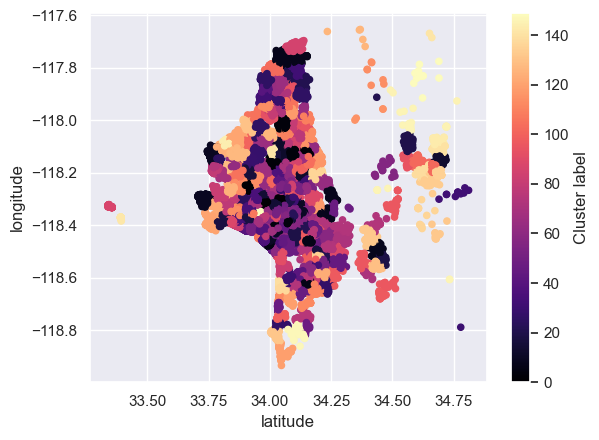

In [84]:
#Getting unique labels
X['Cluster label'] = clusters
X.plot.scatter('latitude', 'longitude', c='Cluster label', colormap='magma')
plt.show()

In [85]:
df.loc[:,"cluster_num"] = kmeans.labels_

In [86]:
df['hotness_in_cluster_by_num_of_reviews'] = 0
df['hotness_in_cluster_by_num_of_reviews_per_month'] = 0

for i in np.arange(0,num_of_clusters):        
    df.loc[df['cluster_num'] == i, 'hotness_in_cluster_by_num_of_reviews'] = df[df['cluster_num'] == i]['number_of_reviews'].sum()
    df.loc[df['cluster_num'] == i, 'hotness_in_cluster_by_num_of_reviews_per_month'] = df[df['cluster_num'] == i]['reviews_per_month'].sum()

df['hotness_in_cluster_by_num_of_reviews'] = df['hotness_in_cluster_by_num_of_reviews']/df['hotness_in_cluster_by_num_of_reviews'].max()
df['hotness_in_cluster_by_num_of_reviews_per_month'] = df['hotness_in_cluster_by_num_of_reviews_per_month']/df['hotness_in_cluster_by_num_of_reviews_per_month'].max()

In [87]:
df[['hotness_in_cluster_by_num_of_reviews']].min(),df[['hotness_in_cluster_by_num_of_reviews']].max()

(hotness_in_cluster_by_num_of_reviews    0.004015
 dtype: float64,
 hotness_in_cluster_by_num_of_reviews    1.0
 dtype: float64)

In [88]:
df[['hotness_in_cluster_by_num_of_reviews_per_month']].min(),df[['hotness_in_cluster_by_num_of_reviews_per_month']].max()

(hotness_in_cluster_by_num_of_reviews_per_month    0.006047
 dtype: float64,
 hotness_in_cluster_by_num_of_reviews_per_month    1.0
 dtype: float64)

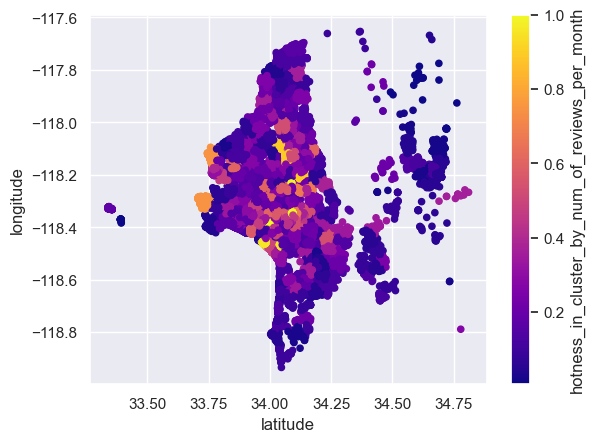

In [89]:
df.plot.scatter('latitude', 'longitude', c='hotness_in_cluster_by_num_of_reviews_per_month', colormap='plasma')
plt.show()

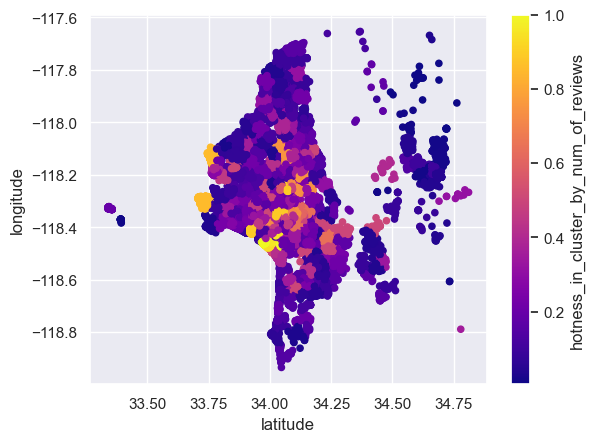

In [90]:
df.plot.scatter('latitude', 'longitude', c='hotness_in_cluster_by_num_of_reviews', colormap='plasma')
plt.show()

In [43]:
cluster_array = np.arange(50,550,50)
X = df[['latitude','longitude']]

for j in cluster_array:
    ## Make a KMeans object
    kmeans = KMeans(j,
                    n_init='auto')

    ## Fit the kmeans object
    kmeans.fit(X)
    
    df.loc[:,"cluster_num"] = kmeans.labels_

    df['hotness_in_cluster_by_num_of_reviews'] = 0
    df['hotness_in_cluster_by_num_of_reviews_per_month'] = 0

    for i in np.arange(0,j):        
        df.loc[df['cluster_num'] == i, 'hotness_in_cluster_by_num_of_reviews'] = df[df['cluster_num'] == i]['number_of_reviews'].sum()
        df.loc[df['cluster_num'] == i, 'hotness_in_cluster_by_num_of_reviews_per_month'] = df[df['cluster_num'] == i]['reviews_per_month'].sum()

    df['hotness_in_cluster_by_num_of_reviews'] = df['hotness_in_cluster_by_num_of_reviews']/df['hotness_in_cluster_by_num_of_reviews'].max()
    df['hotness_in_cluster_by_num_of_reviews_per_month'] = df['hotness_in_cluster_by_num_of_reviews_per_month']/df['hotness_in_cluster_by_num_of_reviews_per_month'].max()

    file_savename = f"listings_mar2023_w_hotspots_and_{j}_clusters.csv"
    df.to_csv(f"../{file_savename}")
    print("done")



done
done
done
done
done
done
done
done
done
done


In [79]:
# #creates a map that has the shape of the united states

# fig = go.Figure(data=go.Scattergeo(
#         lon = df['longitude'],
#         lat = df['latitude'],
#         text = 'Num of reviews: ' + df['hotness_in_cluster_by_num_of_reviews_per_month'].astype(str),
#         marker_size = (df['hotness_in_cluster_by_num_of_reviews_per_month'])
#         ))
# fig.update_geos(fitbounds="locations")
# fig.update_layout(
#         title = 'Hotness based on number of reviews per month at each cluster',
# )
# fig.show()
